# Getting Started with Lamoom

Welcome to Lamoom - your platform for building, testing, and optimizing LLM prompts at scale!

This notebook will guide you through:
1. Setting up your environment
2. Creating a simple prompt
3. Testing prompt quality with real-world data
4. Analyzing and visualizing results

Let's begin by installing the necessary packages.

In [ ]:
# Install required packages
! pip install lamoom
! pip install openai
! pip install pandas
! pip install python-dotenv

## Step 1: Environment Setup

For this tutorial, we'll import the necessary libraries and set up our environment. 
Go to to https://portal.lamoom.com/settings/api_tokens and generate for you a new token, set as LAMOOM_API_TOKEN; 

> **Note:** You'll need to have an `.env` file with your API keys or set them as environment variables. Lamoom supports multiple LLM providers including OpenAI, Claude, Azure OpenAI, and more.

In [2]:
# Import core libraries and load environment variables
import sys
sys.path.append('..')
import dotenv
dotenv.load_dotenv()
import pandas as pd

## Step 2: Creating Your First Prompt

Lamoom uses a simple but powerful prompt creation interface. A Prompt object serves as a container for your prompt template, which can include dynamic variables enclosed in `{variable_name}` syntax.

Below, we'll create a medical question-answering prompt:

In [3]:
from lamoom import Prompt

# Create a prompt with unique ID
agent = Prompt("answer_on_medical_question")

# Add instructions with a dynamic variable for the question
agent.add("""Answer on medical question of the user:
{question}
          
Please first think out loud before answering.
""", role="system")

# The {question} placeholder will be filled with actual questions at runtime

## Step 3: Setting up the Lamoom Client

Now let's initialize the Lamoom client with your API keys. We'll also set up the testing pipeline that will help us evaluate our prompt quality.

In [4]:
import os
from lamoom import Lamoom
from lamoom.response_parsers.response_parser import get_json_from_response

# Get API keys from environment variables
openai_key = os.getenv("OPENAI_API_KEY")

# Initialize the Lamoom client
client = Lamoom(openai_key=openai_key)

In [5]:
# Load our test dataset
data_df = pd.read_csv('./test_data/medical_questions_answers.csv')

# Take a peek at the data
data_df.head()

,question,answer_provided_by_human
0,I have a headache that won't go away. What cou...,"Headaches can have many causes, including stre..."
1,I've been feeling tired all the time lately. W...,Fatigue can be a symptom of various conditions...
2,I have a cough that's been lingering for weeks...,A persistent cough can be a sign of several co...
3,I've noticed a lump in my breast. Is it cancer?,"Finding a lump in your breast can be alarming,..."
4,My child has a fever. When should I take them ...,Fever is a common symptom in children and can ...


In [6]:
# Process each test case
results = []
for index, row in data_df.iterrows():
    print(f"Processing test case {index+1}/{len(data_df)}")
    
    # Extract question and ideal answer from our dataset
    question = row['question']
    ideal_answer = row['answer_provided_by_human']
    
    try:
        # Prepare the context (variables that will be injected into our prompt)
        context = {
            'question': question,
            'ideal_answer': ideal_answer,  # This won't be shown to the LLM but used for evaluation
        }
        
        # Call the LLM with our prompt, context, and model
        # The test_data parameter enables automatic test creation in Lamoom
        response = client.call(
            agent.id,             # The prompt ID we created earlier
            context,              # Variables to inject into the prompt
            'openai/o3-mini',      # The model to use
            test_data={
                'ideal_answer': ideal_answer  # Reference answer for creating tests in Lamoom https://lamoom.com
            }
        )
        results.append({
            'question': question,
            'ideal_answer': ideal_answer,
            'response': response.content,
        })
        
    except Exception as e:
        print(f"Error processing test case {index}: {e}")

Processing test case 1/20
Processing test case 2/20
Processing test case 3/20
Processing test case 4/20
Processing test case 5/20
Processing test case 6/20
Processing test case 7/20
Processing test case 8/20
Processing test case 9/20
Processing test case 10/20
Processing test case 11/20
Processing test case 12/20
Processing test case 13/20
Processing test case 14/20
Processing test case 15/20
Processing test case 16/20
Processing test case 17/20
Processing test case 18/20
Processing test case 19/20
Processing test case 20/20


## Step 6: Visualize Test Results Online

Lamoom provides built-in visualization tools to help you understand your prompt's performance. Let's view a summary of our test results:

## Step 6: Visualize Test Results Locally

Lamoom provides built-in visualization tools to help you understand your prompt's performance. Let's view a summary of our test results:

In [ ]:
! pip install lamoom_cicd

from lamoom_cicd import TestLLMResponsePipe
# Initialize testing pipeline
lamoom_pipe = TestLLMResponsePipe(openai_key=openai_key)

In [ ]:
# Process each test case
cicd_pipeline_results = []
for row in results:
    try:
        # Compare the LLM's response to our ideal answer
        test_result = lamoom_pipe.compare(row['ideal_answer'], row['response'], optional_params={'question': row['question']})
        # Store the results for later analysis
        lamoom_pipe.accumulated_results.append(test_result)
        cicd_pipeline_results.append(test_result)  
    except Exception as e:
        print(f"Error processing test case {index}: {e}")

# Generate visualization of test scores

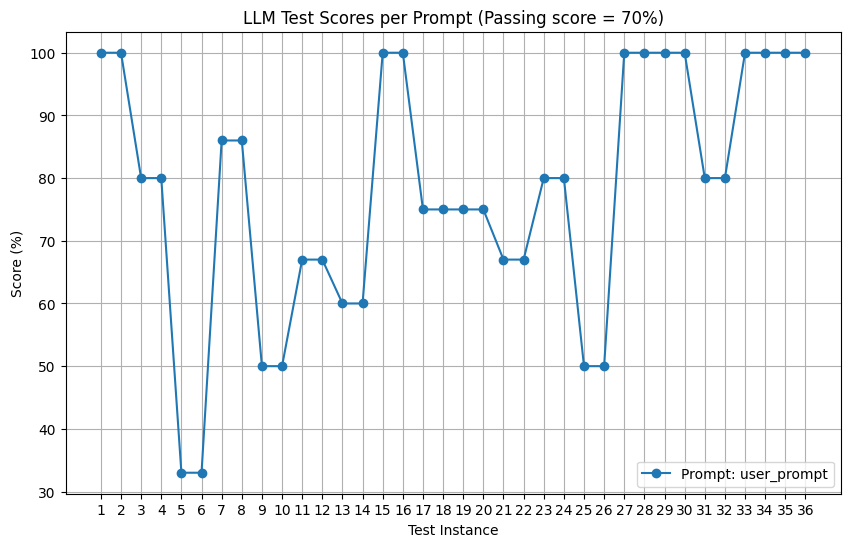

In [9]:
lamoom_pipe.visualize_test_results()

## Step 7: Dive into Detailed Results

The chart above gives us a high-level view of how our prompt performed across test cases. Now let's look at the detailed evaluation for each test case:

In [10]:
# Display detailed results for the first 3 test cases
for i, result in enumerate(cicd_pipeline_results[:3]):
    print(f"\n==== Test Case {i+1} ====")
    print(f"Score: {result.questions[0].does_match_ideal_answer}")
    print(f"\nQuestion: {result.questions[0].test_question}")
    print(f"\nIdeal Answer: {result.questions[0].ideal_answer}")
    print(f"\nModel Response: {result.questions[0].llm_answer}")
    print("\n" + "-"*80)


==== Test Case 1 ====
Score: True

Question: What are some possible causes of headaches?

Ideal Answer: Headaches can have many causes, including stress, dehydration, lack of sleep, or more serious conditions like migraines or sinusitis.

Model Response: The text lists several possible causes of a persistent headache: tension-type headaches (often related to stress, muscle tension, or poor posture), migraines (which may include visual disturbances, nausea, and sensitivity to light and sound), medication overuse (rebound headaches), sinus or cluster headaches, as well as factors like dehydration, lack of sleep, eye strain, and caffeine withdrawal.

--------------------------------------------------------------------------------

==== Test Case 2 ====
Score: True

Question: What can fatigue be a symptom of?

Ideal Answer: Fatigue can be a symptom of various conditions

Model Response: The text explains that fatigue can be a symptom of many causes, including lifestyle factors and underly

## Step 8: Continuous Improvement with Lamoom

Congratulations! You've successfully:
1. Created a prompt with dynamic content
2. Tested it against real-world examples
3. Evaluated and visualized its performance

### What's Next?

With Lamoom, you can take your prompt engineering to the next level:

**🚀 Prompt Management**
- Create, version, and maintain a library of prompts
- Organize prompts by use case, model, or performance metrics

**🧪 Testing & CI/CD**
- Set up automated testing pipelines
- Get alerts when prompt performance degrades
- Compare model performance across different providers

**📊 Analytics**
- Track cost, latency, and usage metrics
- Identify opportunities for optimization
- Monitor prompt performance in production

**🔄 Iterative Development**
- Use the web interface to refine prompts collaboratively
- Run A/B tests on prompt variations
- Deploy without code changes

### Visit Us

- 🌐 [Lamoom Cloud](https://portal.lamoom.com) - Manage all your prompts in one place
- 📚 [Documentation](https://docs.lamoom.com) - Learn all about Lamoom's features
- 🧑‍💻 [GitHub](https://github.com/orgs/lamoom-team) - Check out our open source repositories

---

*Thank you for exploring Lamoom! If you have any questions, reach out to us at support@lamoom.com*